Using device: cuda:1

Starting Epoch [1/10]...


Epoch 1 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.56it/s, loss=0.001863]

Epoch [1/10] Completed. Train Loss: 0.001355, Test Loss: 0.001599


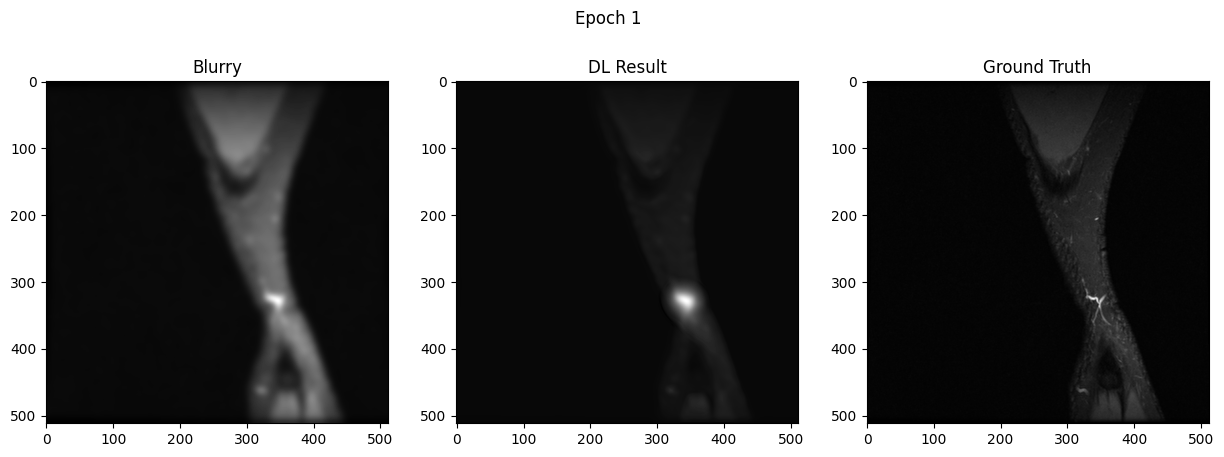


Starting Epoch [2/10]...


Epoch 2 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.63it/s, loss=0.000061]


Epoch [2/10] Completed. Train Loss: 0.000738, Test Loss: 0.000370


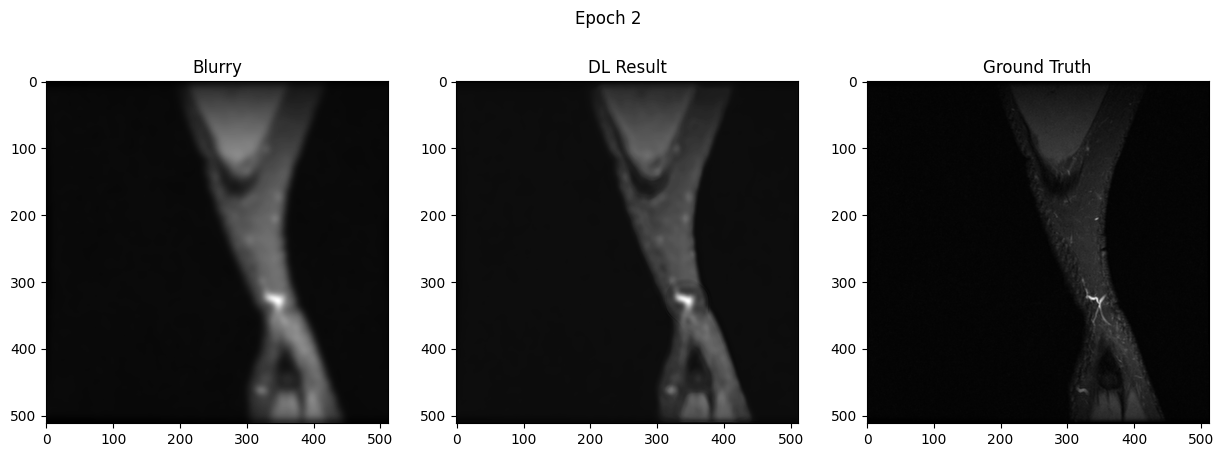


Starting Epoch [3/10]...


Epoch 3 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 81.13it/s, loss=0.000083]

Epoch [3/10] Completed. Train Loss: 0.000650, Test Loss: 0.000344


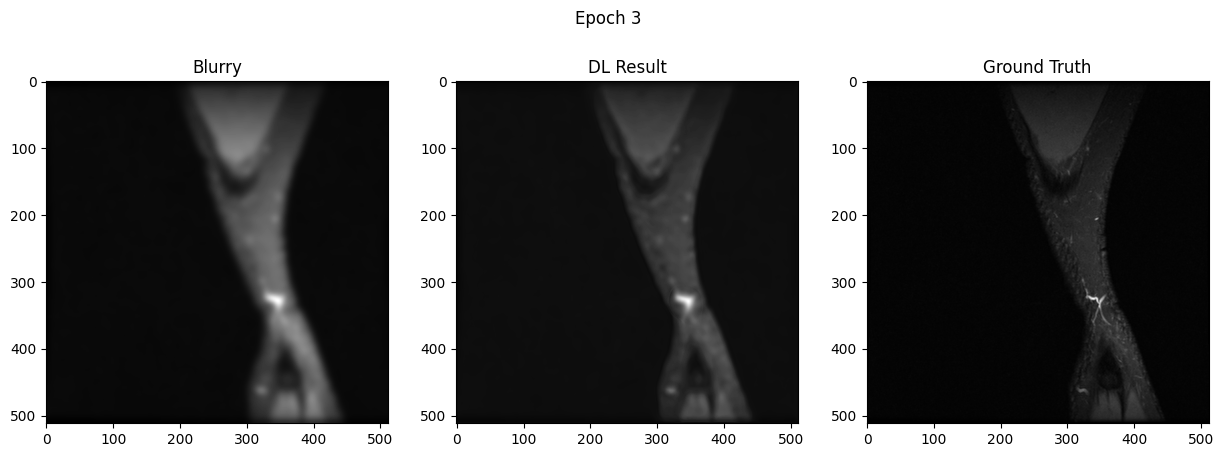


Starting Epoch [4/10]...


Epoch 4 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 81.06it/s, loss=0.000173]

Epoch [4/10] Completed. Train Loss: 0.000673, Test Loss: 0.000462


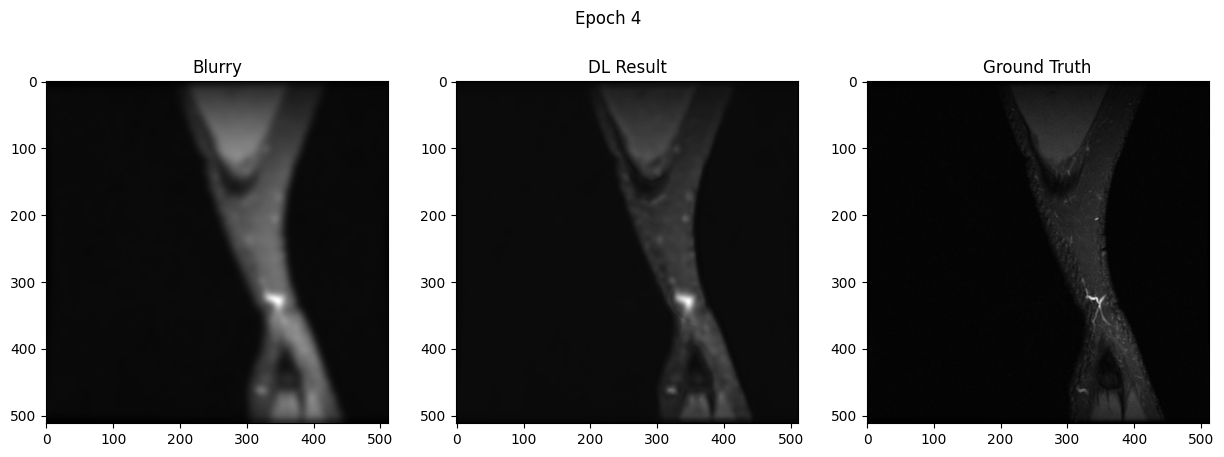


Starting Epoch [5/10]...


Epoch 5 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.27it/s, loss=0.000059]

Epoch [5/10] Completed. Train Loss: 0.000579, Test Loss: 0.000279


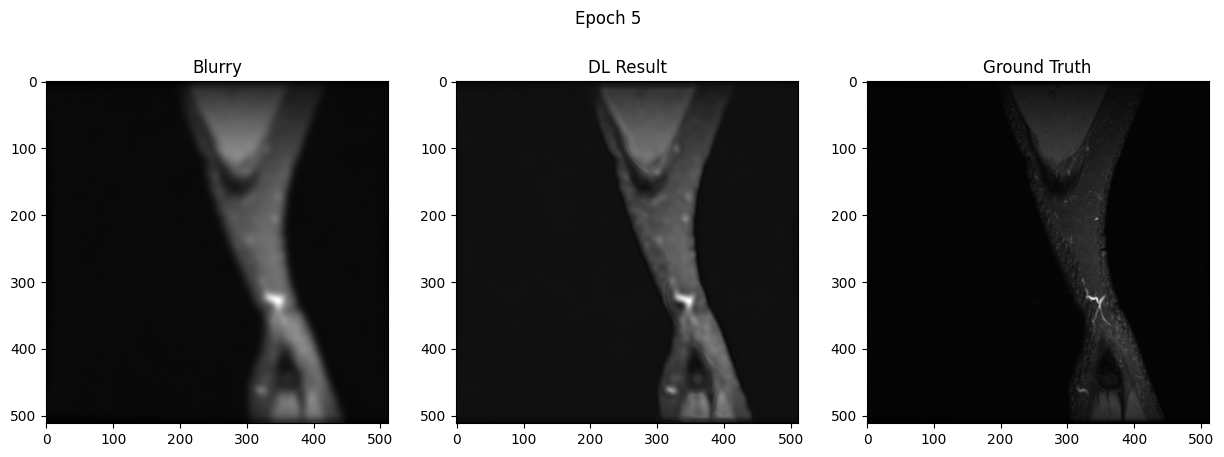


Starting Epoch [6/10]...


Epoch 6 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.61it/s, loss=0.000071]

Epoch [6/10] Completed. Train Loss: 0.000611, Test Loss: 0.000514


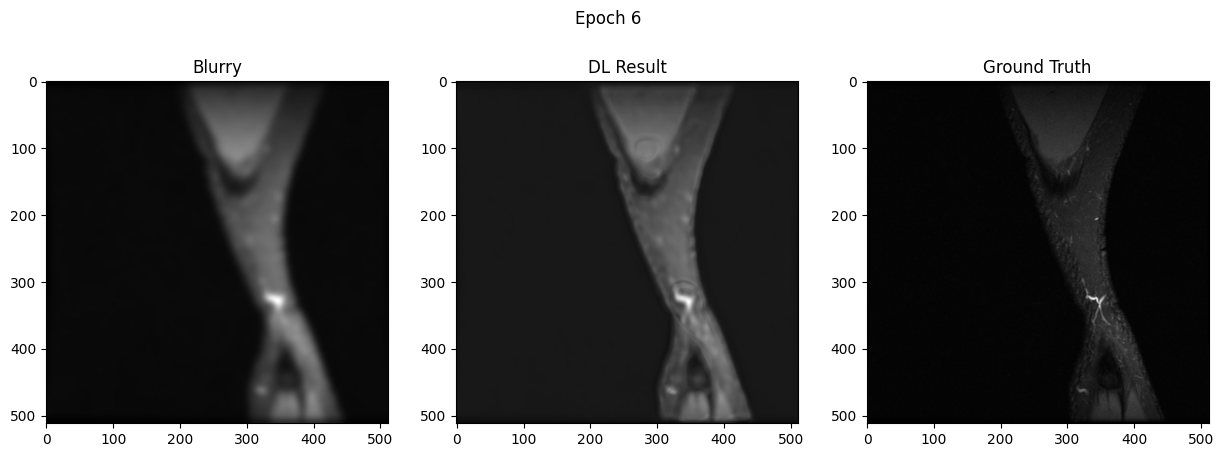


Starting Epoch [7/10]...


Epoch 7 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.64it/s, loss=0.000099]

Epoch [7/10] Completed. Train Loss: 0.000620, Test Loss: 0.000355


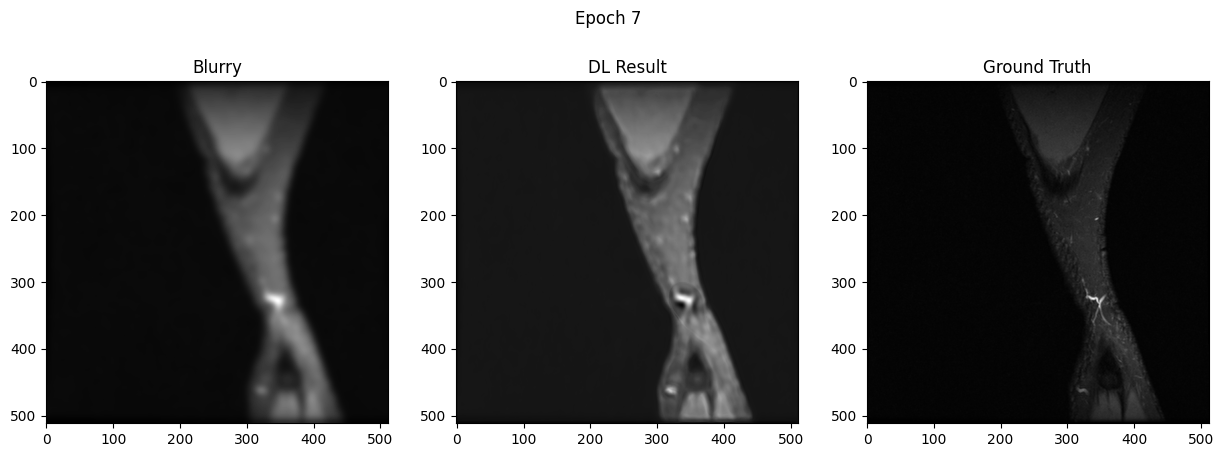


Starting Epoch [8/10]...


Epoch 8 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.04it/s, loss=0.005930]

Epoch [8/10] Completed. Train Loss: 0.000565, Test Loss: 0.007825


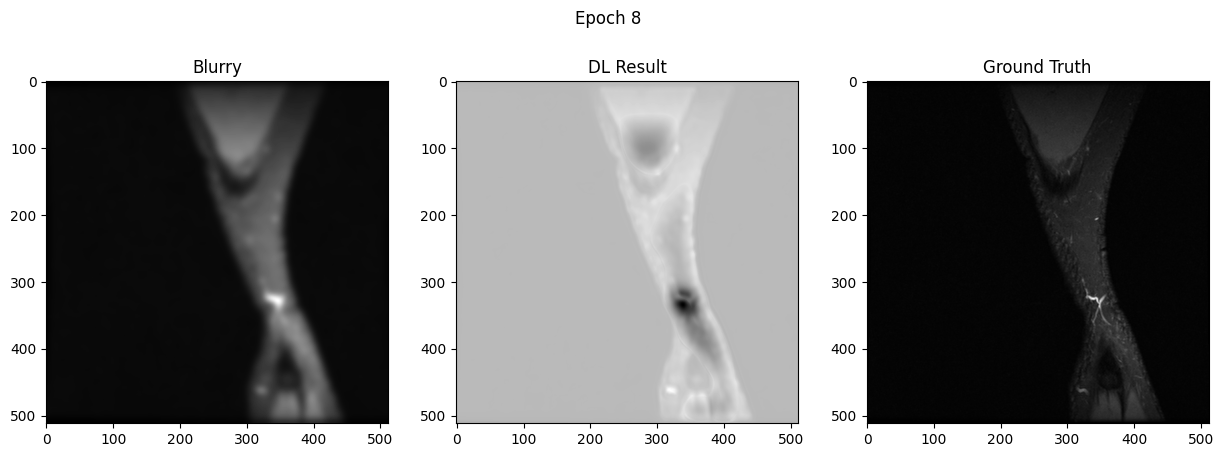


Starting Epoch [9/10]...


Epoch 9 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.71it/s, loss=0.000446]

Epoch [9/10] Completed. Train Loss: 0.000588, Test Loss: 0.000551


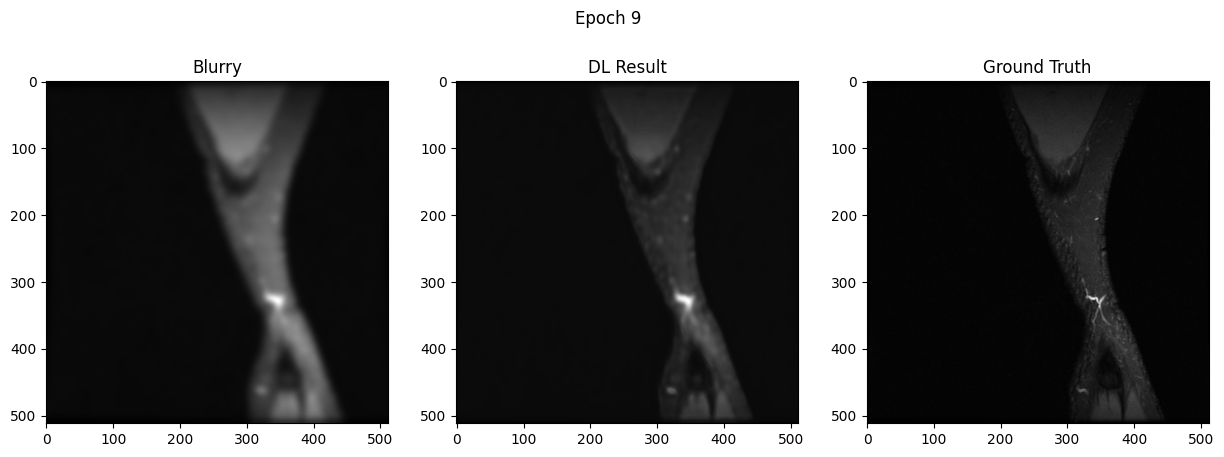


Starting Epoch [10/10]...


Epoch 10 Testing: 100%|██████████| 1000/1000 [00:12<00:00, 80.72it/s, loss=0.000557]

Epoch [10/10] Completed. Train Loss: 0.000558, Test Loss: 0.000937


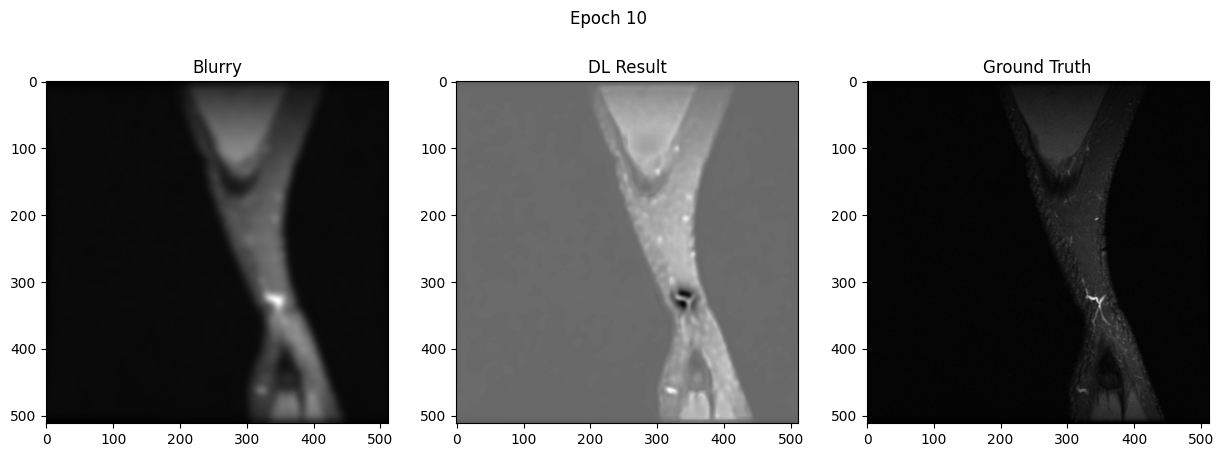

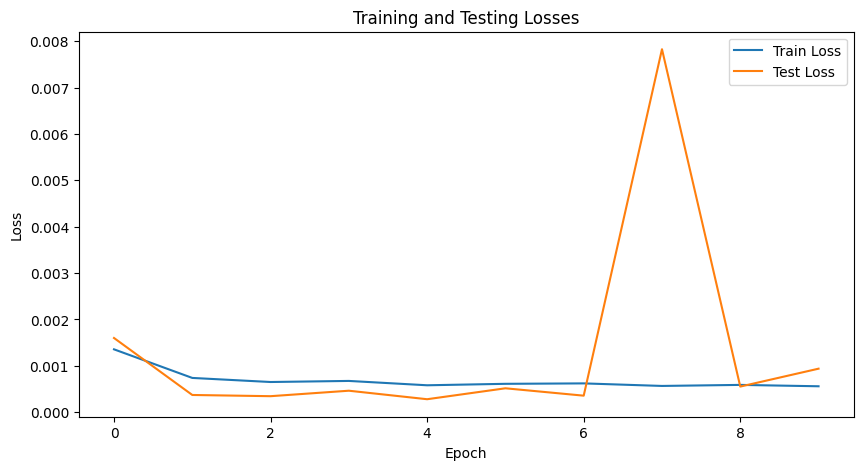

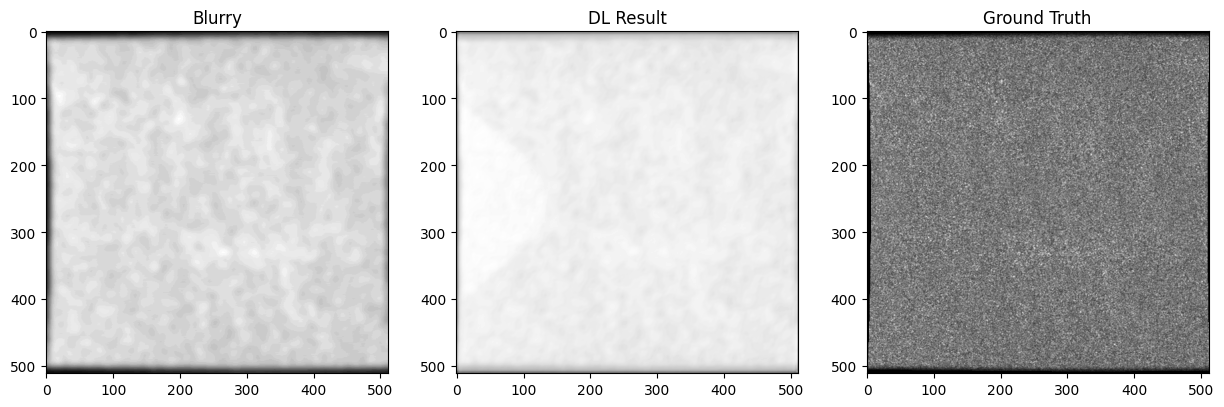

MSE: 0.0001
PSNR: 42.48 dB
SSIM: 0.1383


In [1]:
import os
import h5py
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt
from tqdm import tqdm

class MRIDataset(Dataset):
    def __init__(self, blurry_dir, original_dir):
        self.samples = []
        self.hdf5_objects = {}

        blurry_files = [f for f in os.listdir(blurry_dir) if f.endswith('.h5')]
        original_files = [f for f in os.listdir(original_dir) if f.endswith('.h5')]

        for blurry_file in blurry_files:
            if not blurry_file.startswith("changed_"):
                raise ValueError(f"Blurry file {blurry_file} does not start with 'changed_'")
            corresponding_original_file = blurry_file[8:]  # Remove "changed_" prefix
            if corresponding_original_file not in original_files:
                raise ValueError(f"No corresponding original file for {blurry_file}")

            blurry_path = os.path.join(blurry_dir, blurry_file)
            original_path = os.path.join(original_dir, corresponding_original_file)
            
            with h5py.File(blurry_path, 'r') as f:
                num_slices = f['volume'].shape[0]
            
            for i in range(num_slices - 2):
                self.samples.append((blurry_path, original_path, i))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        blurry_file, original_file, start_slice = self.samples[idx]
        
        if blurry_file not in self.hdf5_objects:
            self.hdf5_objects[blurry_file] = h5py.File(blurry_file, 'r')
        blurry_f = self.hdf5_objects[blurry_file]
        
        if original_file not in self.hdf5_objects:
            self.hdf5_objects[original_file] = h5py.File(original_file, 'r')
        original_f = self.hdf5_objects[original_file]
        
        blurry = np.array(blurry_f['volume'][start_slice:start_slice+3])
        original = np.array(original_f['volume'][start_slice+1])
        
        blurry = torch.from_numpy(blurry).float()
        original = torch.from_numpy(original).float().unsqueeze(0)
        
        return blurry, original

    def close_all_files(self):
        for f in self.hdf5_objects.values():
            f.close()
        self.hdf5_objects.clear()

class UNet2D(nn.Module):
    def __init__(self):
        super(UNet2D, self).__init__()
        
        self.enc1 = self.conv_block(3, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)
        
        self.dec4 = self.conv_block(512 + 256, 256)
        self.dec3 = self.conv_block(256 + 128, 128)
        self.dec2 = self.conv_block(128 + 64, 64)
        self.dec1 = nn.Conv2d(64, 1, kernel_size=3, padding=1)
        
        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.maxpool(e1))
        e3 = self.enc3(self.maxpool(e2))
        e4 = self.enc4(self.maxpool(e3))
        
        d4 = self.dec4(torch.cat([self.upsample(e4), e3], dim=1))
        d3 = self.dec3(torch.cat([self.upsample(d4), e2], dim=1))
        d2 = self.dec2(torch.cat([self.upsample(d3), e1], dim=1))
        out = self.dec1(d2)
        
        return out

def calculate_ssim(img1, img2):
    return ssim(img1, img2, data_range=img2.max() - img2.min())

def plot_losses(train_losses, test_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Testing Losses')
    plt.show()

def visualize_sample(model, test_loader, device, epoch):
    model.eval()
    with torch.no_grad():
        for blurry, original in test_loader:
            blurry = blurry.to(device)
            original = original.to(device)
            
            # 检查 original 的最大值，如果小于 0.8 继续处理下一个图像对
            if original.max().item() < 0.8:
                continue
            
            output = model(blurry)
            
            fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
            ax1.imshow(blurry[0, 1].cpu().numpy(), cmap='gray')
            ax1.set_title('Blurry')
            ax2.imshow(output[0, 0].cpu().numpy(), cmap='gray')
            ax2.set_title('DL Result')
            ax3.imshow(original[0, 0].cpu().numpy(), cmap='gray')
            ax3.set_title('Ground Truth')
            plt.suptitle(f'Epoch {epoch+1}')
            plt.show()
            break

def train(model, train_loader, criterion, optimizer, device, epoch_idx):
    model.train()
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch_idx+1} Training")
    for blurry, original in progress_bar:
        blurry = blurry.to(device)
        original = original.to(device)
        
        optimizer.zero_grad()
        output = model(blurry)
        loss = criterion(output, original)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({'loss': f'{loss.item():.6f}'})
    
    return total_loss / len(train_loader)

def test(model, test_loader, criterion, device, epoch_idx):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        progress_bar = tqdm(test_loader, desc=f"Epoch {epoch_idx+1} Testing")
        for blurry, original in progress_bar:
            blurry = blurry.to(device)
            original = original.to(device)
            output = model(blurry)
            loss = criterion(output, original)
            total_loss += loss.item()
            progress_bar.set_postfix({'loss': f'{loss.item():.6f}'})
    
    return total_loss / len(test_loader)

def main():
    device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    
    train_dataset = MRIDataset(blurry_hdf5_dir, original_hdf5_dir)
    train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4)
    
    test_dataset = MRIDataset(blurry_test_hdf5_dir, original_test_hdf5_dir)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)
    
    model = UNet2D()
    #if torch.cuda.device_count() > 1:
    #    model = nn.DataParallel(model)
    #    print(f"Using {torch.cuda.device_count()} GPUs!")
    #else:
    #        print("Using single GPU.")
    model = model.to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    num_epochs = 10
    train_losses = []
    test_losses = []
    for epoch in range(num_epochs):
        print(f"\nStarting Epoch [{epoch+1}/{num_epochs}]...")
        train_loss = train(model, train_loader, criterion, optimizer, device, epoch)
        test_loss = test(model, test_loader, criterion, device, epoch)
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        print(f"Epoch [{epoch+1}/{num_epochs}] Completed. Train Loss: {train_loss:.6f}, Test Loss: {test_loss:.6f}")
        
        visualize_sample(model, test_loader, device, epoch)
    
    plot_losses(train_losses, test_losses)

    torch.save(model.state_dict(), 'unet2d_model_baseline.pth')

    model.eval()
    with torch.no_grad():
        for i, (blurry, original) in enumerate(test_loader):
            if i == 0:
                blurry = blurry.to(device)
                original = original.to(device)
                output = model(blurry)
                
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
                ax1.imshow(blurry[0, 1].cpu().numpy(), cmap='gray')
                ax1.set_title('Blurry')
                ax2.imshow(output[0, 0].cpu().numpy(), cmap='gray')
                ax2.set_title('DL Result')
                ax3.imshow(original[0, 0].cpu().numpy(), cmap='gray')
                ax3.set_title('Ground Truth')
                plt.show()
                
                mse = nn.MSELoss()(output, original).item()
                psnr = 10 * np.log10(1 / mse)
                
                output_np = output[0, 0].cpu().numpy()
                original_np = original[0, 0].cpu().numpy()
                ssim_value = calculate_ssim(output_np, original_np)
                
                print(f"MSE: {mse:.4f}")
                print(f"PSNR: {psnr:.2f} dB")
                print(f"SSIM: {ssim_value:.4f}")
                break

    train_dataset.close_all_files()
    test_dataset.close_all_files()

if __name__ == "__main__":
    blurry_hdf5_dir = '../hdf5/blurry'
    original_hdf5_dir = '../hdf5/original'
    blurry_test_hdf5_dir = '../hdf5/blurry_test'
    original_test_hdf5_dir = '../hdf5/original_test'
    main()
